In [1]:
cd

C:\Users\56961


In [2]:
cd Desktop\portafolio

C:\Users\56961\Desktop\portafolio


In [3]:
get_ipython().magic('reset -sf')

In [4]:

# cargar librerias

# definir librerias
import scipy.stats as st
import random
import numpy as np
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import networkx as nx
import pickle 
from collections import Counter
import csv

import networkx.algorithms.isomorphism as iso

import scipy.io as sio
import numpy as np
from datetime import datetime

import seaborn as sns
import pandas as pd
import numpy as np
import io

import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import warnings
warnings.filterwarnings('ignore')


C:\Users\56961\AppData\Local\Temp\ipykernel_9324\4258104686.py:31: UserWarning: DelftStack
  warnings.warn('DelftStack')


# Cargar  data frame con los resultados de la experimentación.

In [5]:
name_df="data frame/df_resumen_exp_reales"
file = open(name_df, 'rb')
df_experimentacion= pickle.load(file)
file.close()

df_experimentacion['Num_metodo_est'] = df_experimentacion['Num_metodo_est'].replace("PIMPLE", "PIMLE")
df_experimentacion['Num_metodo_est'] = df_experimentacion['Num_metodo_est'].replace("EMV", "MLE")

df_experimentacion = df_experimentacion.reset_index(drop=True)                
l_grupos=list(df_experimentacion['Etiqueta H'].unique())
df_experimentacion.head(2)

,Id_sample,Etiqueta H,Tipo_sample_p_gral,Porc_nodos_muestra,Num_metodo_est,Valor_Estimado,Valor_error(Exac - Est),Valor_error_rel(Exac - Est)
0,0,views<=520,5,0.01,PIMLE,17457.068133,-942.068133,-0.057043
1,0,views<=520,5,0.01,MLE,17314.057061,-799.057061,-0.048384


In [6]:
def graficar_IC(df_contexto,size_figure,dict_position_legend,dict_met_to_ylim,LabelGrupo,factor):
    dict_col_to_R2={u:v for u,v in zip(list(range(0,4)),[(0,0),(0,1),(1,0),(1,1)]) }
    
    L_prop_sample=[0.01,0.1,0.5,0.9]  # row size sample listo
    x_dom=L_prop_sample

    l_tipo_sample=['5', '6', '7', '8']
    #l_tipo_sample=['5', '6']    
    cant_filas=len(l_tipo_sample)
    cant_colums=1

    L_met_est=['PIMLE','MLE','GNSUM','RDS_I','RDS_II']   # grafica i #
    cant_graficas=len(L_met_est)
    dict_num_graph_to_est={u:v for u,v in zip(range(cant_graficas),L_met_est)}
    Lalfa=[1,1,0.7,0.7,0.7]    
    dict_met_to_alfa={u:v for u,v in zip(L_met_est,Lalfa)}      
    l_ancho=[1.6,1.6,1.6,1,1.6]
    l_ancho=[2.5,2.5,2.5,2.5,2.5]
    dict_met_to_ancho={u:v for u,v in zip(L_met_est,l_ancho)}    

    fig, axes = plt.subplots(int(cant_filas/2),2, figsize=size_figure, sharex=False, sharey=False)    
    fig.suptitle("Aproximación intervalo de confianza al 95% ("+LabelGrupo+").")        
    list_ylim=[]
    list_row_col=[]
    
    
    for num_row in range(cant_filas):     # Tipo_sample_p_gral
        sample_method=l_tipo_sample[num_row]
        df_sample=df_contexto[df_contexto["Tipo_sample_p_gral"]==sample_method]
        for grafica_i in range(cant_graficas): # metodo estimador

            metodo_est=L_met_est[grafica_i]
            df_graphics=df_sample[df_sample["Num_metodo_est"]==metodo_est]  # grafica_i            

            lista_mean=[]
            l_up_estimador=[]
            for porc_sample in L_prop_sample: # x dom 
                df_x=df_graphics[df_graphics["Porc_nodos_muestra"]==porc_sample]                
                datos=list(df_x["Valor_error_rel(Exac - Est)"])                

                mean_datos=np.mean(datos)
                lista_mean.append(mean_datos)
                IC_fix_porc_inf=list(st.t.interval(0.95, len(datos)-1, loc=mean_datos, scale=st.sem(datos)))
                up_fix_porc_inf=IC_fix_porc_inf[1]-mean_datos
                #l_up_estimador.append(abs(np.log(up_fix_porc_inf)))
                l_up_estimador.append(up_fix_porc_inf/factor)

            name_label=metodo_est
            f,c=dict_col_to_R2[num_row]
            axes[f,c].scatter(x_dom,lista_mean,s=5,marker='o',label=name_label)   #list_marker=['^','o',"1"]
            #axes[f,c].scatter(x_dom,lista_mean,s=5,marker='o')   #list_marker=['^','o',"1"]            
            
            ancho=dict_met_to_ancho[metodo_est]
            PAlfa=dict_met_to_alfa[metodo_est]
            axes[f,c].errorbar(x_dom, lista_mean, yerr=l_up_estimador, fmt=":", linewidth=ancho,alpha=PAlfa)
            #axes[f,c].errorbar(x_dom, lista_mean, yerr=l_up_estimador, fmt=":", linewidth=ancho,alpha=PAlfa,label=name_label)            
            
            if True: #if metodo_est=="RDS_II" or metodo_est=="RDS_I":
                line = axes[f,c].get_lines()[-1]# Obtén la línea del gráfico actual
                line.set_linestyle("-.")# Cambia el estilo de la línea a punteado                
                line.set_alpha(0.4)                    
            
        axes[f,c].grid(True) 
        ylabel="Err. Rel ( Tipo muestreo "+str(sample_method)+")."
        axes[f,c].set_ylabel(ylabel,fontsize=14)

        xlabel="Prop. de muestra con resp. a N."
        axes[f,c].set_xlabel(xlabel,fontsize=14)

        Titulo="IC de la Esp. Er. rel para TM "+str(sample_method)
        axes[f,c].set_title(Titulo)
        
        ylim=dict_met_to_ylim[num_row]
        axes[f,c].set_ylim(ylim)
        
        posit_legend=dict_position_legend[num_row]
        axes[f,c].legend(loc=posit_legend,prop={'size': 12}, framealpha=0.1)
                
    plt.tight_layout()                
    return list_ylim,list_row_col
    

,Id_sample,Etiqueta H,Tipo_sample_p_gral,Porc_nodos_muestra,Num_metodo_est,Valor_Estimado,Valor_error(Exac - Est),Valor_error_rel(Exac - Est)
0,0,views<=520,5,0.01,PIMLE,17457.068133,-942.068133,-0.057043
1,0,views<=520,5,0.01,MLE,17314.057061,-799.057061,-0.048384
2,0,views<=520,5,0.01,GNSUM,15883.948392,631.051608,0.038211
3,0,views<=520,5,0.01,RDS_I,15282.634407,1232.365593,0.074621
4,0,views<=520,5,0.01,RDS_II,17301.440809,-786.440809,-0.047620
...,...,...,...,...,...,...,...,...
63995,99,language_JA,8,0.90,PIMLE,1224.450572,102.549428,0.077279
63996,99,language_JA,8,0.90,MLE,1270.235919,56.764081,0.042776
63997,99,language_JA,8,0.90,GNSUM,1335.200072,-8.200072,-0.006179
63998,99,language_JA,8,0.90,RDS_I,1279.237119,47.762881,0.035993


# Grafica IC caso estimaciones en general

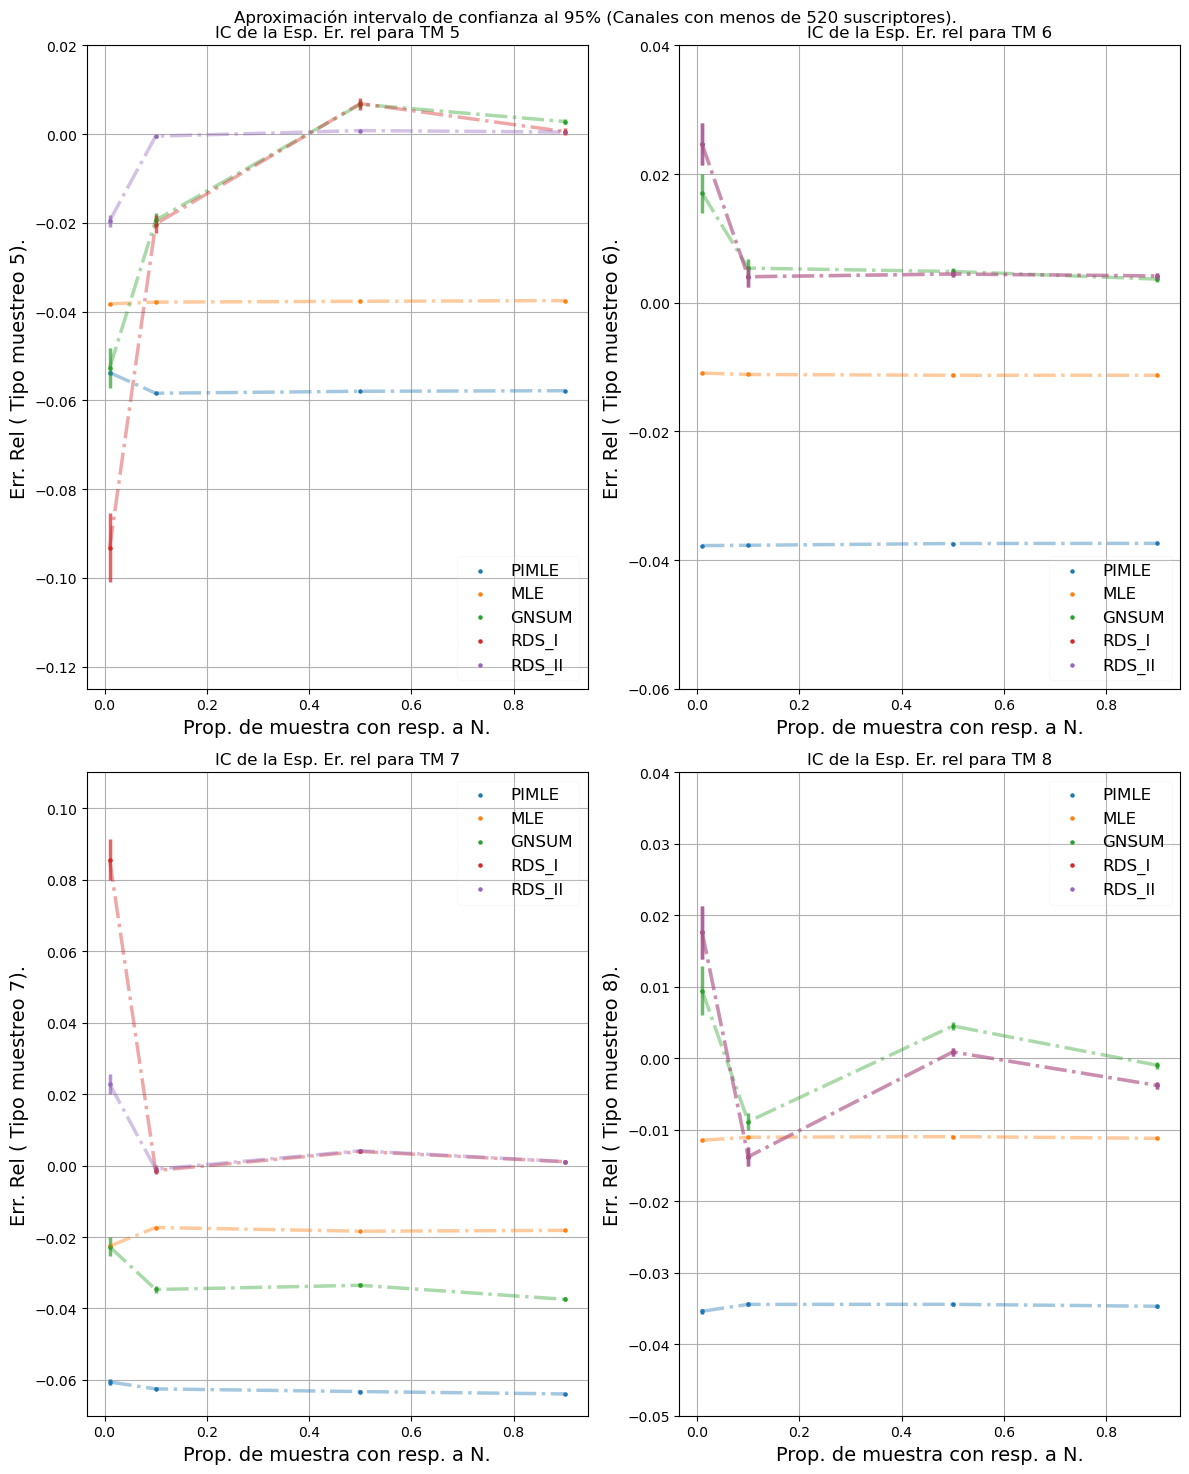

In [20]:
size_figure=(12/1,15/1)
LabelGrupo="Canales con menos de 520 suscriptores"
l_position=["lower right","lower right","upper right","upper right","upper right","upper right","upper right","upper right" ]
dict_position_legend={u:z for u,z in zip(list(range(0,4)),l_position) }

# dict_3:
l_ylim=[[-0.2,0.08]]
l_ylim=[[-10,10],[-0.08,0.08],[-0.08,0.15],[-0.08,0.08]]
l_ylim=[[-10,10],[-0.08,0.08],[-0.08,0.15],[-0.08,0.08]]
l_ylim=[[-0.125,0.02],[-0.06,0.04],[-0.07,0.11],[-0.05,0.04]]
l_ylim=[[-0.125,0.02],[-0.1,0.05],[-0.07,0.11],[-1,1]]
l_ylim=[[-0.125,0.02],[-0.06,0.04],[-0.07,0.11],[-0.05,0.04]]
l_correction=[0,0,0,0]
for i in range(len(l_ylim)):
    x,y=l_ylim[i]
    l_ylim[i]=x+l_correction[i],y+l_correction[i]
dict_met_to_ylim={u:v for u,v in zip(list(range(0,4)),l_ylim)}

#cond_grupo_2=df_experimentacion["Num_metodo_est"]=="RDS_I"
cond_grupo_2=df_experimentacion["Num_metodo_est"]!="RDS_III"
cond_grupo_1=df_experimentacion['Etiqueta H']==l_grupos[0]
df_contexto=df_experimentacion[cond_grupo_1 &cond_grupo_2]
factor=10

list_ylim,list_row_col=graficar_IC(df_contexto,size_figure,dict_position_legend,dict_met_to_ylim,LabelGrupo,factor)


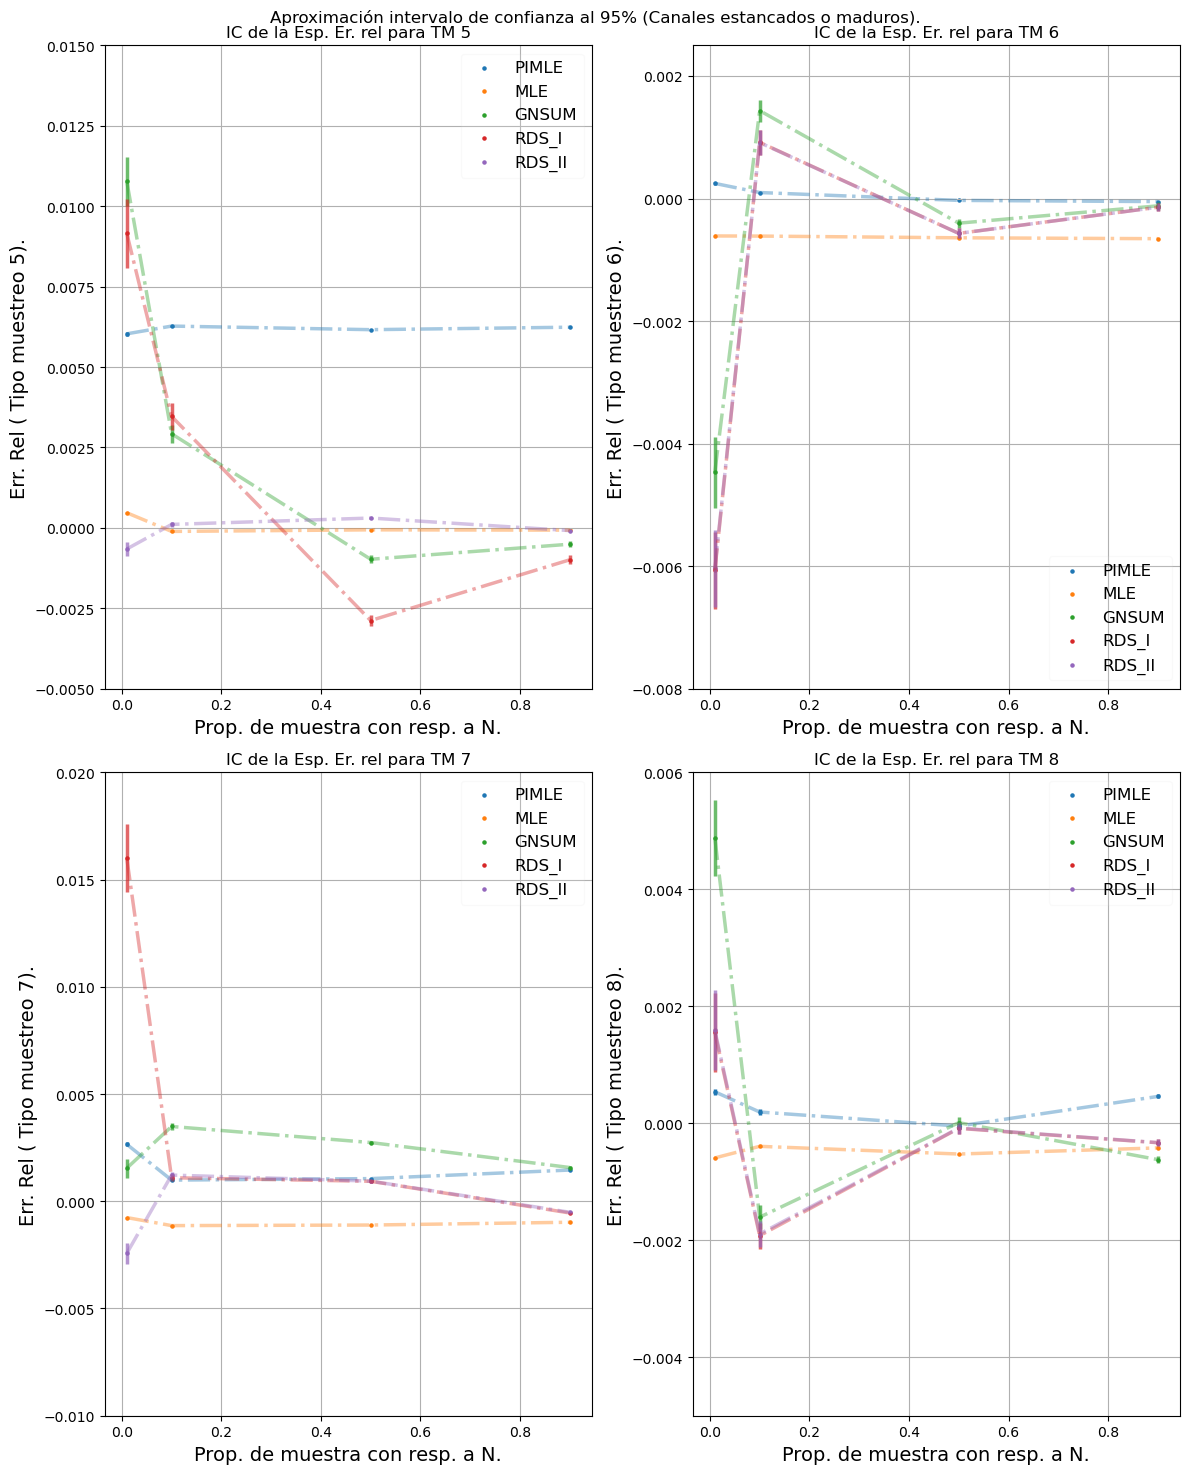

In [21]:
size_figure=(12,15)
LabelGrupo="Canales estancados o maduros"
l_position=["upper right","lower right","upper right","upper right","upper right","upper right","upper right","upper right" ]
dict_position_legend={u:z for u,z in zip(list(range(0,4)),l_position) }

# dict_3:

l_Base=[-0.01,-0.01,-0.01,-0.01]
delta=0.035
l_ylim=[]
for i in range(len(l_Base)):
    l_ylim.append([l_Base[i],l_Base[i]+delta])
    
l_ylim=[[-0.005,0.015],[-0.008,0.0025],[-0.01,0.02],[-0.005,0.006]]
dict_met_to_ylim={u:v for u,v in zip(list(range(0,4)),l_ylim)}


cond_grupo_1=df_experimentacion['Etiqueta H']==l_grupos[1]
df_contexto=df_experimentacion[cond_grupo_1]
factor=20

list_ylim,list_row_col=graficar_IC(df_contexto,size_figure,dict_position_legend,dict_met_to_ylim,LabelGrupo,factor)


([(-0.013162470596091257, 0.033731396522556675),
  (-0.0207166467467697, 0.00829838491957102),
  (-0.01989179516669862, 0.0497283092400225),
  (-0.014158361511535279, 0.01902576182151289),
  (-0.12453188634698012, 0.10267531357274651),
  (-0.03637234691985193, 0.05480859670296146),
  (-0.025596415155997976, 0.16764429540431813),
  (-0.01650289656494726, 0.07117778406805049)],
 [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (3, 1)])

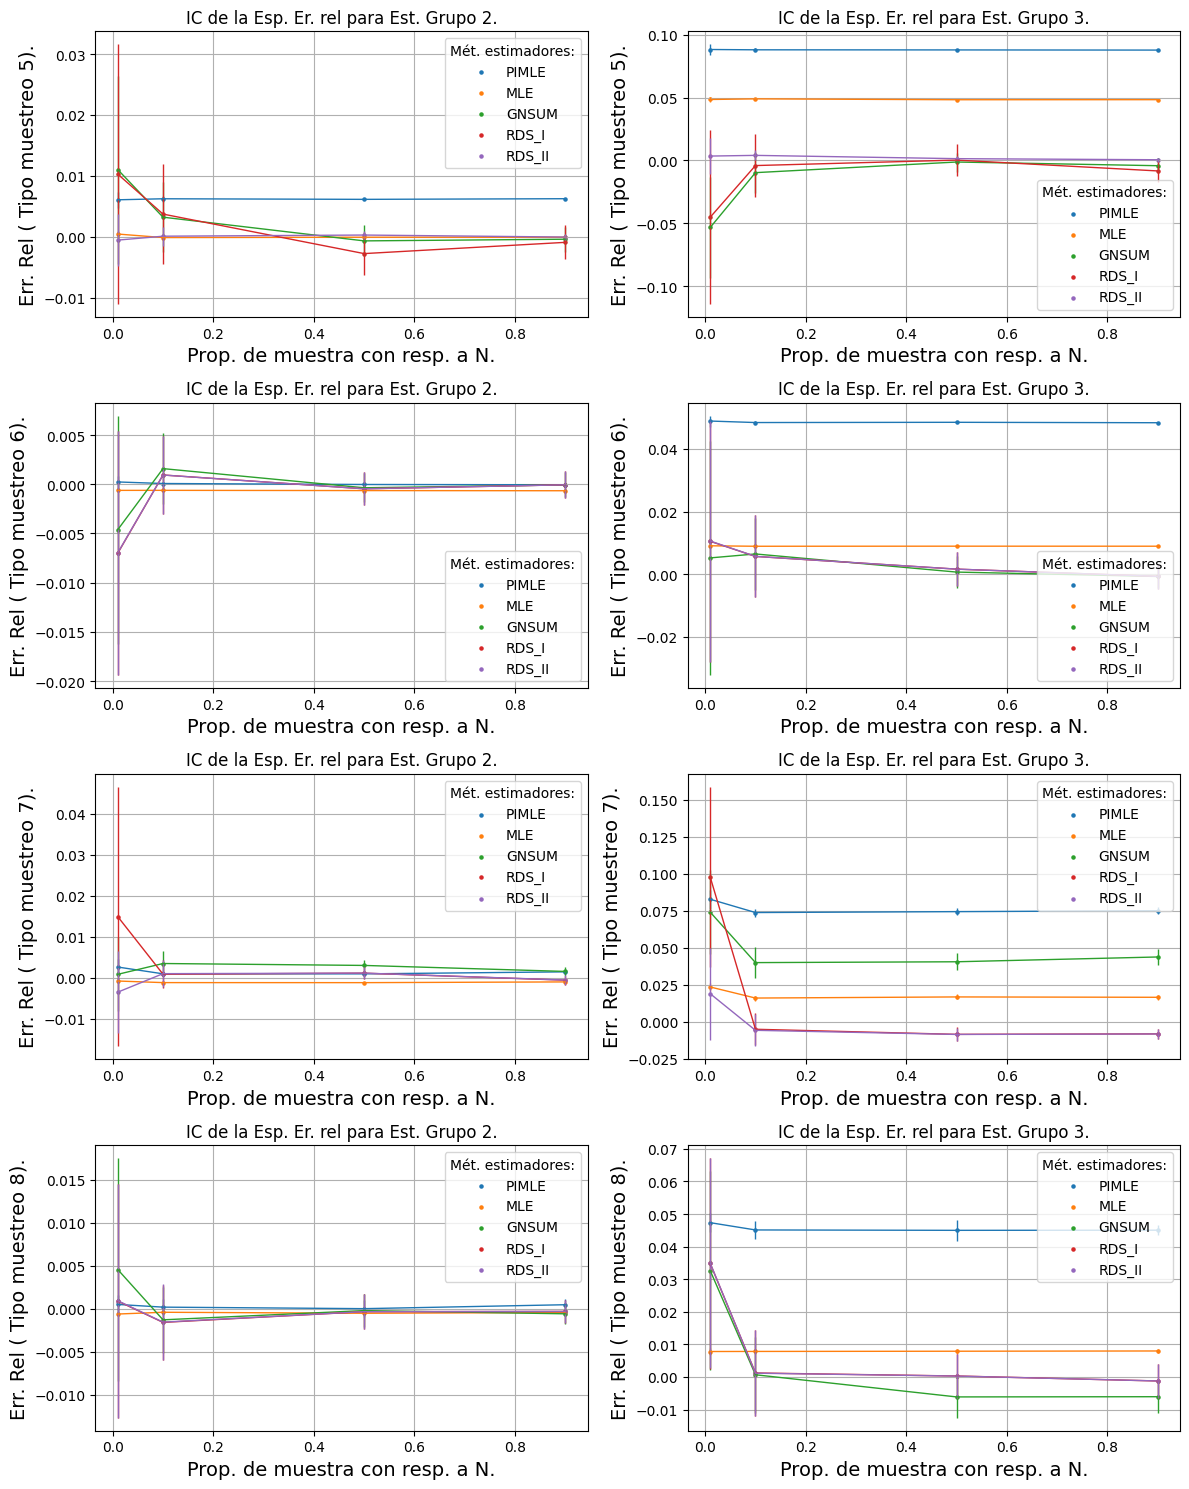

In [23]:
size_figure=(12,15)
l_ylim=[[-1.5,0.1],[-0.45,0.1],[-0.45,0.1],[-0.45,0.1]]
dict_met_to_ylim={u:v for u,v in zip(L_prop_sample,l_ylim)}

# dict_2:
l_position=["upper right","lower right","lower right","lower right","upper right","upper right","upper right","upper right"]
dict_position_legend={(u[0],u[1]):z for u,z in zip(list_cuadr_graphics,l_position) }

cond_grupo_1=df_experimentacion['Etiqueta H']==l_grupos[1]
cond_grupo_2=df_experimentacion['Etiqueta H']==l_grupos[2]
l_cond=[cond_grupo_1,cond_grupo_2]


L_met_est=['PIMLE','MLE','GNSUM','RDS_I','RDS_II']
l_ancho=[1.6,1.6,1.6,1,1.6]
dict_met_to_ancho={u:v for u,v in zip(L_met_est,l_ancho)}

l_name_grupo=["Grupo 2","Grupo 3"]
graficar_IC(df_experimentacion,l_cond,dict_met_to_ylim,size_figure,l_name_grupo,dict_position_legend,dict_y_lim)

([(-0.34209466195611027, 0.062394679063943706),
  (-0.01471140646460674, 0.31287822666143356),
  (-0.03598680310829021, 0.006025494393901969),
  (-0.0181556125573869, 0.130055619822204),
  (-0.11620716121594218, 0.08099313755677157),
  (-0.07382975915225008, 0.12264295553226723),
  (-0.021300494334075618, 0.0023432225647828176),
  (-0.020039472993423537, 0.004915317921713292)],
 [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (3, 1)])

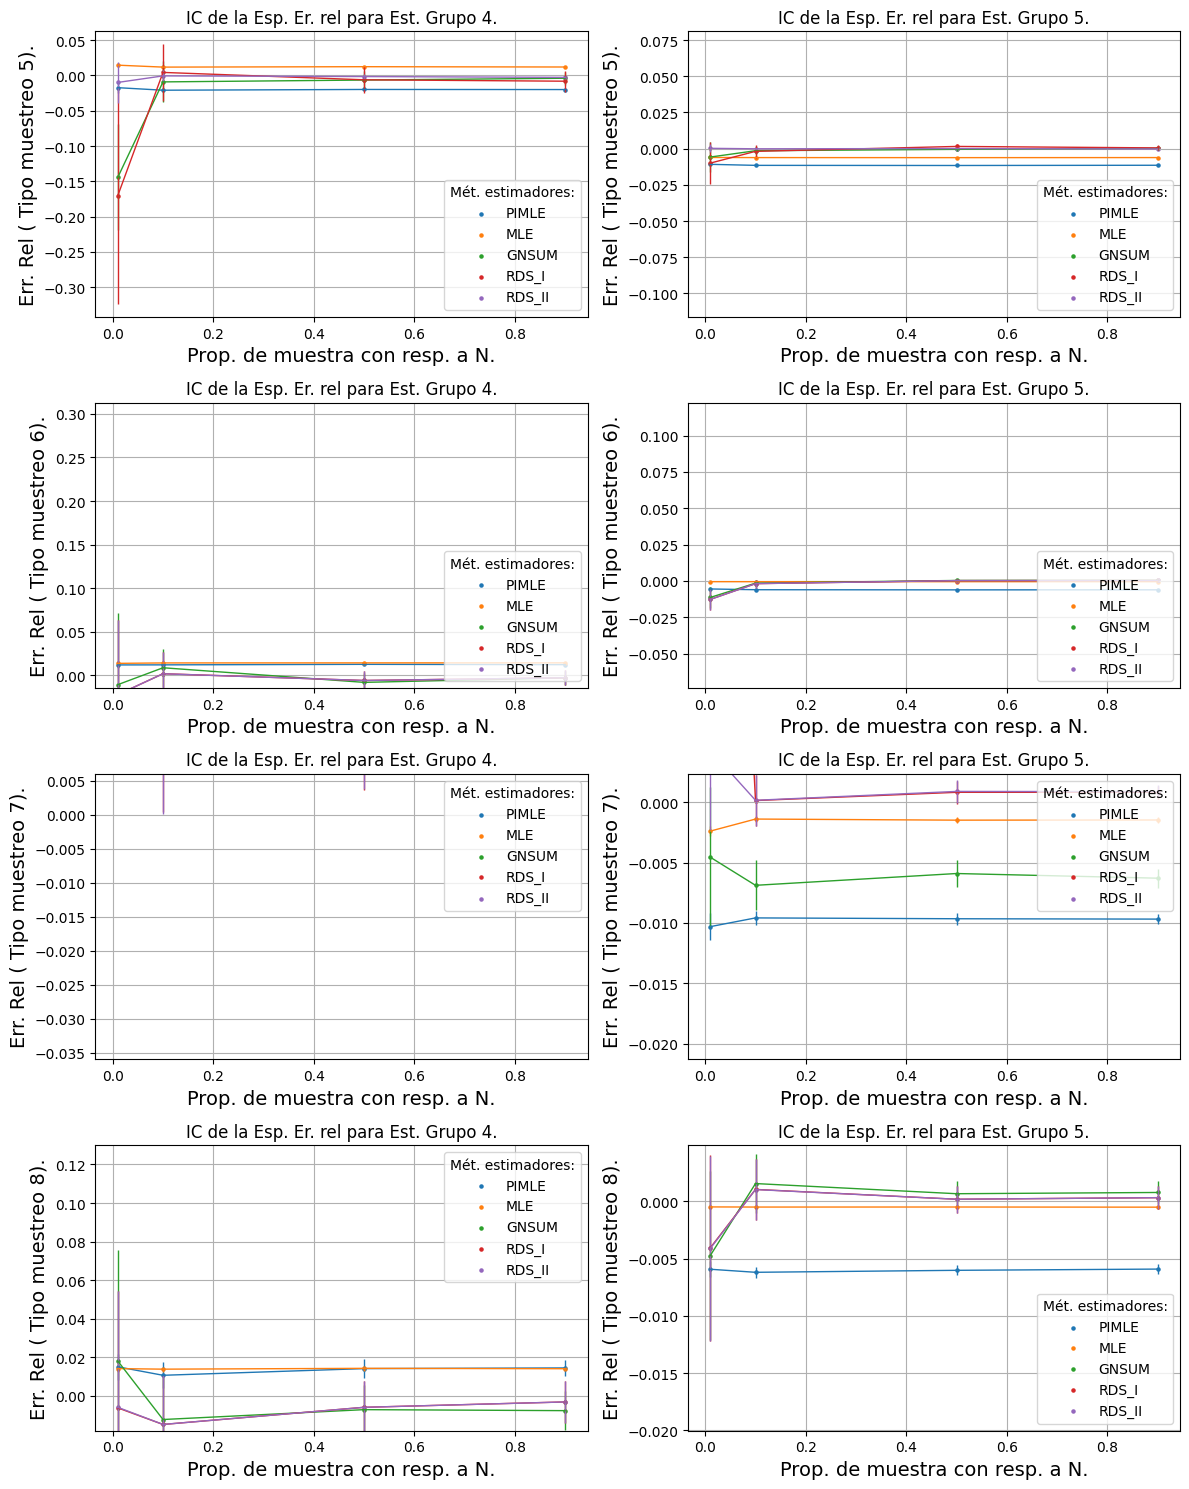

In [127]:
size_figure=(12,15)
l_ylim=[[-1.5,0.1],[-0.45,0.1],[-0.45,0.1],[-0.45,0.1]]
dict_met_to_ylim={u:v for u,v in zip(L_prop_sample,l_ylim)}


# dict_2:
l_position=["lower right","lower right","lower right","lower right","upper right","upper right","upper right","lower right"]
dict_position_legend={(u[0],u[1]):z for u,z in zip(list_cuadr_graphics,l_position) }

# dict_3:
l_y_lim=[(-0.34209466195611027, 0.062394679063943706),
  (-0.11620716121594218, 0.08099313755677157),
  (-0.01471140646460674, 0.31287822666143356),
  (-0.07382975915225008, 0.12264295553226723),
  (-0.035986803108290206, 0.006025494393901969),
  (-0.021300494334075618, 0.0023432225647828176),
  (-0.0181556125573869, 0.130055619822204),
  (-0.020039472993423538, 0.004915317921713292)]
dict_y_lim={(u[0],u[1]):z for u,z in zip(list_cuadr_graphics,l_y_lim) }

cond_grupo_1=df_experimentacion['Etiqueta H']==l_grupos[3]
cond_grupo_2=df_experimentacion['Etiqueta H']==l_grupos[4]
l_cond=[cond_grupo_1,cond_grupo_2]

l_name_grupo=["Grupo 4","Grupo 5"]
graficar_IC(df_experimentacion,l_cond,dict_met_to_ylim,size_figure,l_name_grupo,dict_position_legend,dict_y_lim)

([(-0.1870492615965218, 0.07414555421781634),
  (-0.03465890808935335, 0.10231426691534955),
  (-0.05655542125602648, 0.27687882037037354),
  (-0.07384994552642082, 0.060460024639686784),
  (-0.9439638436571538, 0.1295375703217601),
  (-0.4074348541167572, 0.16562918189833142),
  (-0.8413694425241055, 0.5620463273791707),
  (-0.4248750782485646, 0.27196004351407865)],
 [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (3, 1)])

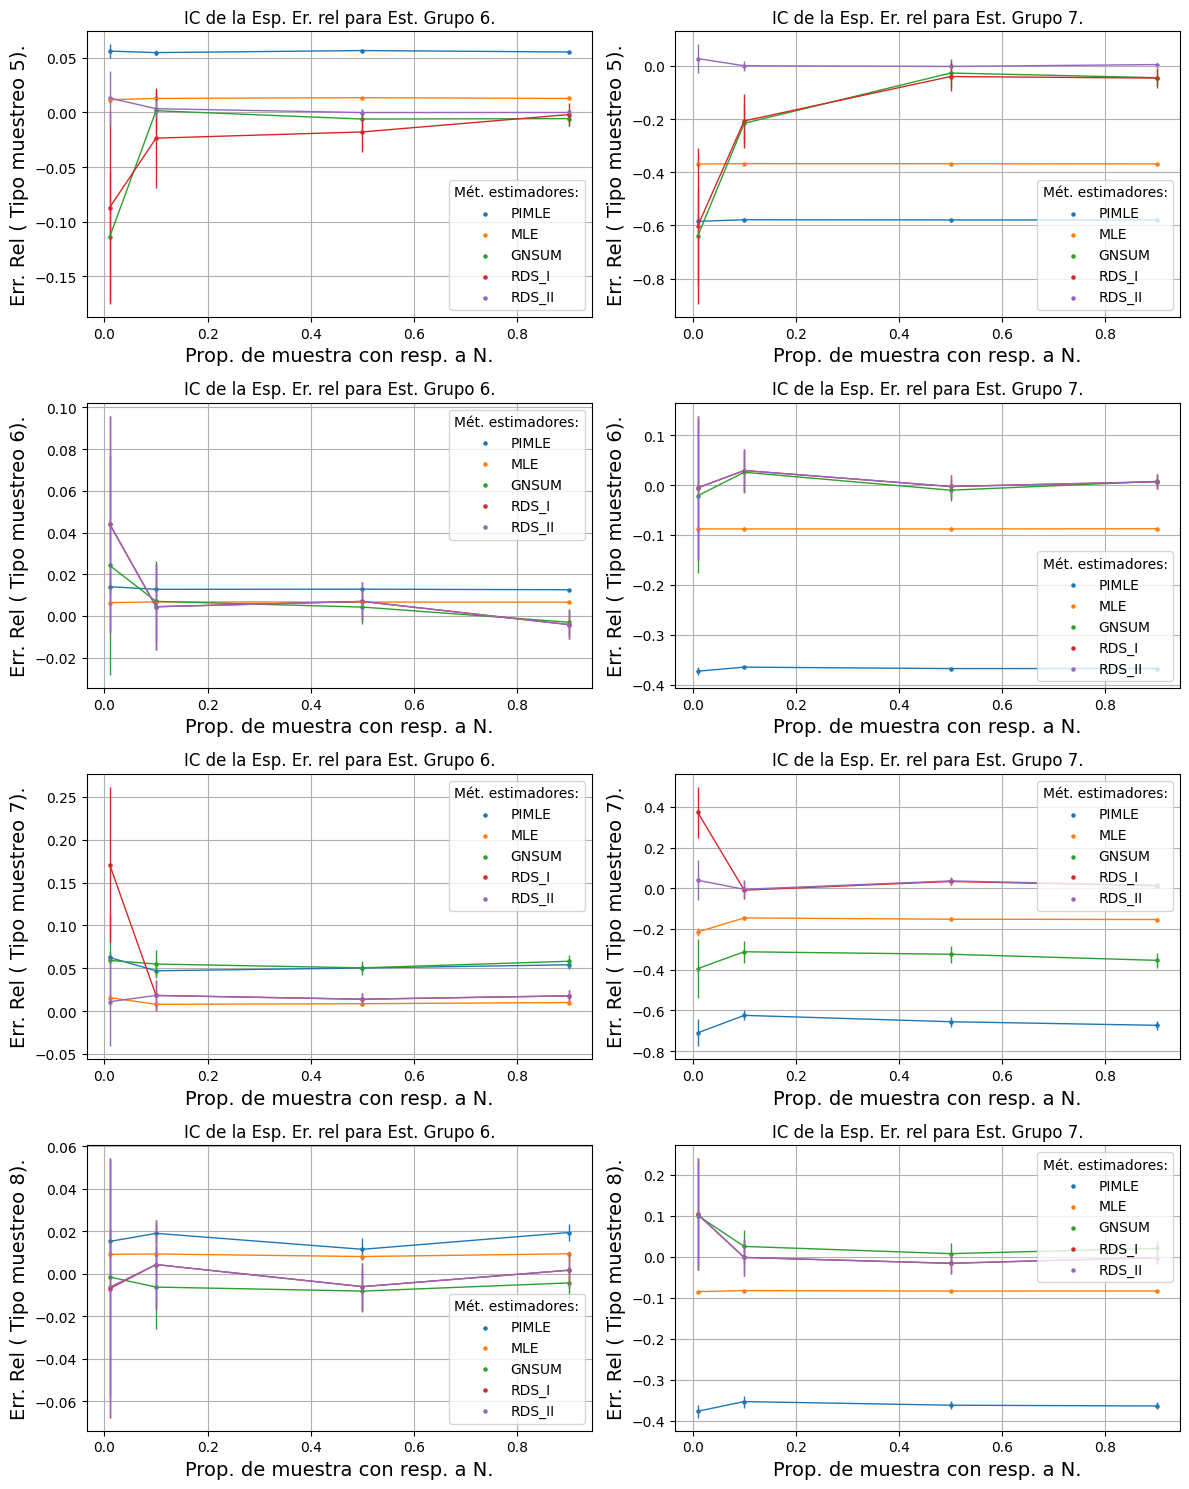

In [24]:
size_figure=(12,15)
l_ylim=[[-1.5,0.1],[-0.45,0.1],[-0.45,0.1],[-0.45,0.1]]
dict_met_to_ylim={u:v for u,v in zip(L_prop_sample,l_ylim)}

l_position=["lower right","lower right","upper right","lower right","upper right","upper right","lower right","upper right"]
dict_position_legend={(u[0],u[1]):z for u,z in zip(list_cuadr_graphics,l_position) }

# dict_3:
l_y_lim=[(-0.1870492615965218, 0.07414555421781634),
  (-0.03465890808935335, 0.10231426691534955),
  (-0.05655542125602648, 0.27687882037037354),
  (-0.1084994552642082, 0.060460024639686784),
  (-0.1639638436571538, 0.1295375703217601),
  (-0.4074348541167572, 0.16562918189833142),
  (-0.8413694425241055, 0.8620463273791707),
  (-0.4248750782485646, 0.6)]
dict_y_lim={(u[0],u[1]):z for u,z in zip(list_cuadr_graphics,l_y_lim) }

cond_grupo_1=df_experimentacion['Etiqueta H']==l_grupos[5]
cond_grupo_2=df_experimentacion['Etiqueta H']==l_grupos[6]
l_cond=[cond_grupo_1,cond_grupo_2]

l_name_grupo=["Grupo 6","Grupo 7"]
graficar_IC(df_experimentacion,l_cond,dict_met_to_ylim,size_figure,l_name_grupo,dict_position_legend,dict_y_lim)

([(-1.0832850197690198, 0.2203332416617908),
  (-0.15518594974933225, 0.17188732519515465),
  (-0.11768123694422547, 0.5640780397318128),
  (-0.10960383995622484, 0.28876975008302613),
  (-1.0832850197690198, 0.2203332416617908),
  (-0.15518594974933225, 0.17188732519515465),
  (-0.11768123694422547, 0.5640780397318128),
  (-0.10960383995622484, 0.28876975008302613)],
 [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (3, 1)])

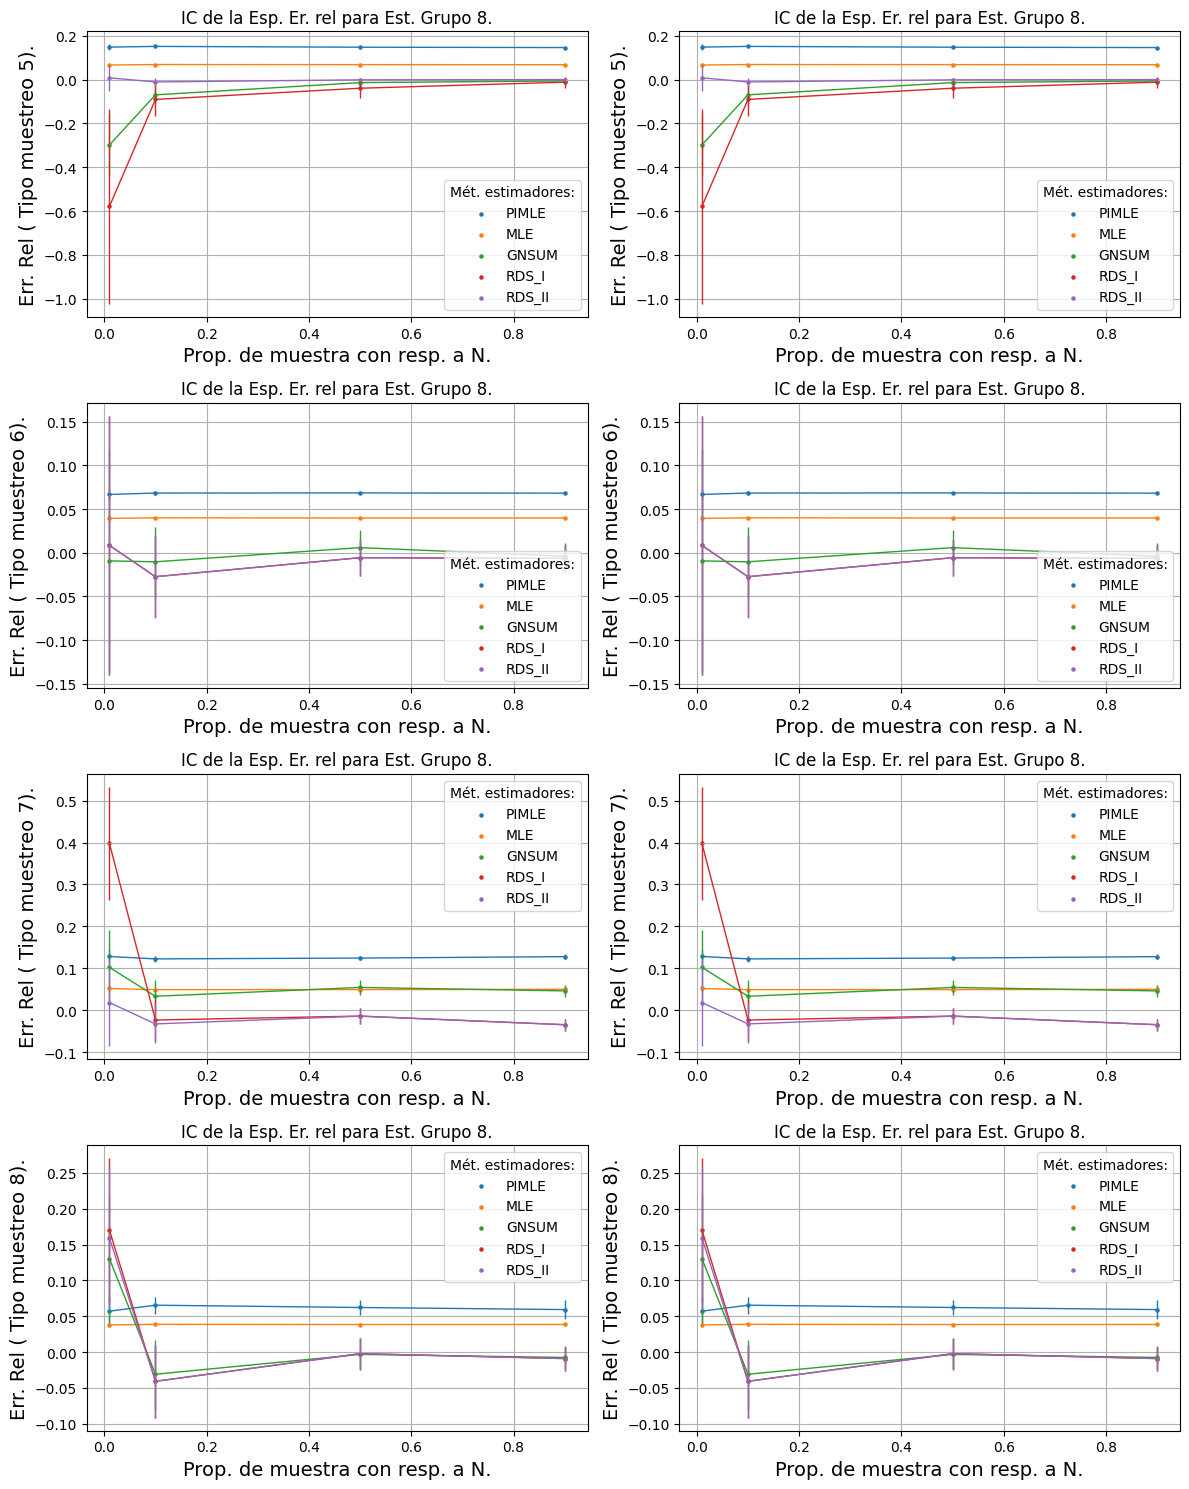

In [25]:
size_figure=(12,15)
l_ylim=[[-1.5,0.1],[-0.45,0.1],[-0.45,0.1],[-0.45,0.1]]
dict_met_to_ylim={u:v for u,v in zip(L_prop_sample,l_ylim)}

l_position=["lower right","lower right","lower right","lower right","upper right","upper right","upper right","upper right"]
dict_position_legend={(u[0],u[1]):z for u,z in zip(list_cuadr_graphics,l_position) }

# dict_3:
l_y_lim=[(-1.0832850197690198, 0.2203332416617908),
  (-0.25518594974933225, 0.17188732519515465),
  (-0.11768123694422547, 0.5640780397318128),
  (-0.10960383995622484, 0.28876975008302613),
  (-1.0832850197690198, 0.2203332416617908),
  (-0.15518594974933225, 0.17188732519515465),
  (-0.11768123694422547, 0.5640780397318128),
  (-0.10960383995622484, 0.28876975008302613)]
dict_y_lim={(u[0],u[1]):z for u,z in zip(list_cuadr_graphics,l_y_lim) }

cond_grupo_1=df_experimentacion['Etiqueta H']==l_grupos[7]
cond_grupo_2=df_experimentacion['Etiqueta H']==l_grupos[7]
l_cond=[cond_grupo_1,cond_grupo_2]

l_name_grupo=["Grupo 8","Grupo 8"]
graficar_IC(df_experimentacion,l_cond,dict_met_to_ylim,size_figure,l_name_grupo,dict_position_legend,dict_y_lim)